### Import Library

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import itertools
import pandas as pd 
import pickle 
import numpy as np
import mne
torch.manual_seed(0)
from nu_smrutils import loaddat

### Select Dataset 


In [3]:
dname = dict(BNCI2014004 = 'aBNCI2014004R.pickle',
             BNCI2014001 = 'aBNCI2014001R.pickle',
             Weibo2014   = 'aWeibo2014R.pickle',
             Physionet   = 'aPhysionetRR.pickle')

In [4]:
# itemname is one of : ['BNCI2014004', 'BNCI2014001', 'Weibo2014', 'Physionet']
itemname = 'BNCI2014001'
filename = dname[itemname]

iname = itemname + '__'    

In [5]:
data = loaddat(filename)

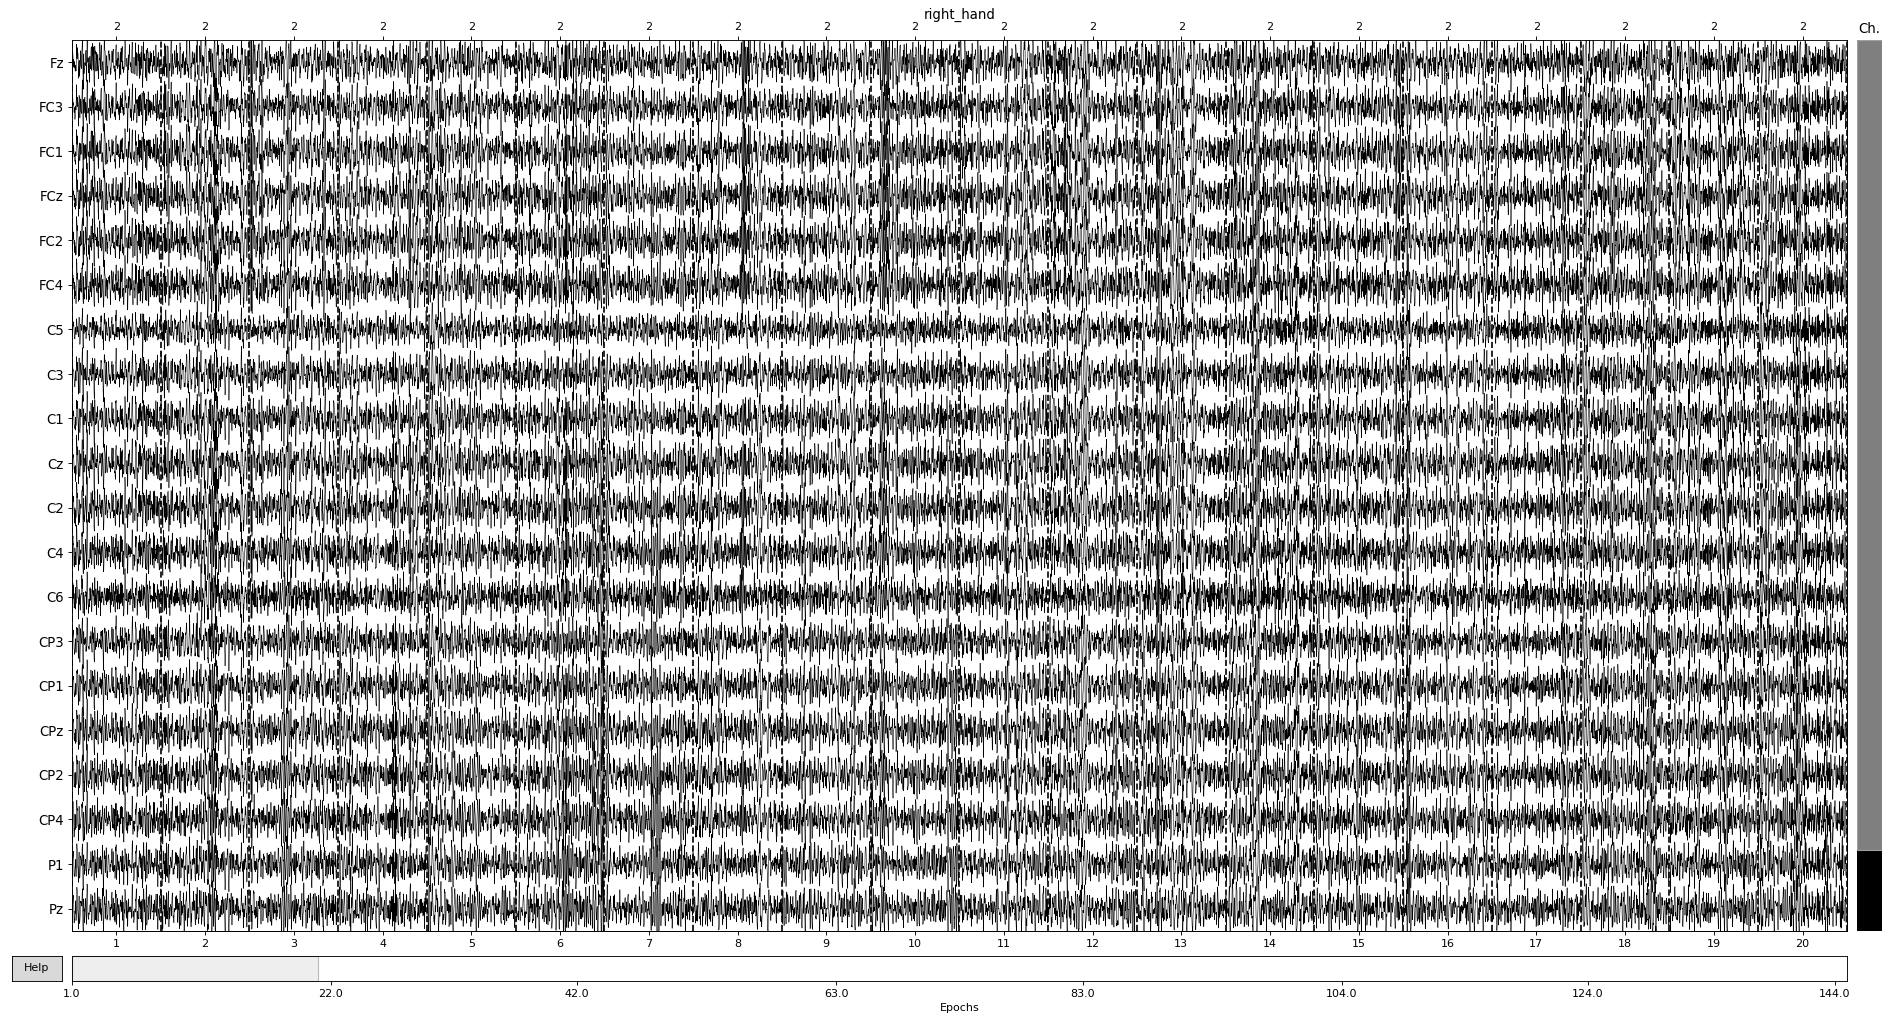

In [6]:
data[0]['right_hand'].plot();

### Load subject specific data

In [10]:
from nu_smrutils import subject_specific 

In [11]:
subjectIndex = list(range(108))
class_name = ['left_hand', 'right_hand']

datt = subject_specific(data, subjectIndex, class_name, 
                        normalize = True, test_size = 0.15)

Loading subject: 0
Loading subject: 1
Loading subject: 2
Loading subject: 3
Loading subject: 4
Loading subject: 5
Loading subject: 6
Loading subject: 7
Loading subject: 8
Loading subject: 9
list index out of range


In [12]:
datt[0].keys()

dict_keys(['xtrain', 'xvalid', 'xtest', 'ytrain', 'yvalid', 'ytest'])

In [13]:
datt[0]['xtrain'].shape

torch.Size([195, 22, 321])

### Subspe Data augmentation 

In [14]:
for dat in datt:    
    print("Data shape :", dat['xtrain'].shape)
datt[0].keys()

Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])
Data shape : torch.Size([195, 22, 321])


dict_keys(['xtrain', 'xvalid', 'xtest', 'ytrain', 'yvalid', 'ytest'])

In [15]:
from nu_smrutils import augment_dataset 

In [16]:
augment_dataset?

Signature: augment_dataset(X, Y, std_dev, multiple)
Docstring:
Augments the size of the dataset by introducing unbiased gaussian noise.
Resulting dataset is 'multiple' times bigger than original.

Parameters:
-------------------------
    X (torch.FloatTensor): Input training data
    Y (torch.FloatTensor): Target training data

    std_dev (float): Standard deviation of gaussian noise to apply
    multiple (int): Factor by how much the dataset should be bigger
File:      ~/Insync/berdakho@gmail.com/Google Drive/__BCI_Pytorch/a_deepMI-notebook/nu_smrutils.py
Type:      function


In [17]:
# augment only the training data 
augmdata = dict(std_dev = 0.01,  multiple = 2)

for ii, dat in enumerate(datt):    
    xtrain, ytrain = augment_dataset(dat['xtrain'], dat['ytrain'], 
                                     std_dev = augmdata['std_dev'], 
                                     multiple = augmdata['multiple'])
    print("Shape after data augmentation :", xtrain.shape)
    datt[ii]['xtrain'], datt[ii]['ytrain'] = xtrain, ytrain

Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])
Shape after data augmentation : torch.Size([390, 22, 321])


### Subspe Data Cropping

In [18]:
from nu_smrutils import crop_data

In [19]:
crop_data?

Signature: crop_data(fs, crop_length, xdata, ylabel, xpercent)
Docstring:
Crop EEG data along time points with pre-defined time segment,
and generate multiple cropped segments.

Parameters:
-----------
fs          : EEG sampling frequency rate
crop_length : length of crop time-window in seconds
xdata       : numpy array of shape (samples, channel, times)
xpercent    : amount of overlap in percentage  
File:      ~/Insync/berdakho@gmail.com/Google Drive/__BCI_Pytorch/a_deepMI-notebook/nu_smrutils.py
Type:      function


In [20]:
fs = 80 # sampling frequency 
crop_len = 1.5 #or None
crop = dict(fs = fs, crop_len = crop_len)

In [21]:
for ii, dat in enumerate(datt):
    if crop['crop_len']:
       X_train, y_train = crop_data(crop['fs'], crop['crop_len'], dat['xtrain'], dat['ytrain'],xpercent = 50)
       X_valid, y_valid = crop_data(crop['fs'], crop['crop_len'], dat['xvalid'], dat['yvalid'],xpercent = 50)
       X_test,  y_test  = crop_data(crop['fs'], crop['crop_len'], dat['xtest'],  dat['ytest'], xpercent = 50)
       
       print(X_train.shape)
       datt[ii] = dict(xtrain = X_train, xvalid = X_valid, xtest = X_test,
                       ytrain = y_train, yvalid = y_valid, ytest = y_test)                      

torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])
torch.Size([780, 22, 180])


### Pytorch dataloaders 

In [22]:
from torch.utils.data import TensorDataset, DataLoader

def get_data_loaders(dat, batch_size, EEGNET = None):    
    # convert data dimensions to into to gray scale image format
    if EEGNET: ### EEGNet model requires the last dimension to be 1 
        ff = lambda dat: torch.unsqueeze(dat, dim = -1)    
    else:
        ff = lambda dat: torch.unsqueeze(dat, dim = 1)    
        
    x_train, x_valid, x_test =  map(ff,(dat['xtrain'],dat['xvalid'],dat['xtest']))    
    y_train, y_valid, y_test =  dat['ytrain'], dat['yvalid'], dat['ytest']
    print('Input data shape', x_train.shape)       
    
    # TensorDataset & Dataloader    
    train_dat = TensorDataset(x_train, y_train) 
    val_dat   = TensorDataset(x_valid, y_valid) 
    
    train_loader = DataLoader(train_dat, batch_size = batch_size, shuffle = True)
    val_loader   = DataLoader(val_dat,   batch_size = batch_size, shuffle = False)

    output = dict(dset_loaders = {'train': train_loader, 'val': val_loader}, 
                  dset_sizes  =  {'train': len(x_train), 'val': len(x_valid)},
                  test_data   =  {'x_test' : x_test, 'y_test' : y_test})          
    return output 

### Subspe dataloaders

In [23]:
for ii, dat in enumerate(datt): #for each dataset 
    datt[ii] = get_data_loaders(dat, batch_size = 64)

Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])
Input data shape torch.Size([780, 1, 22, 180])


In [24]:
datt[0].keys()

dict_keys(['dset_loaders', 'dset_sizes', 'test_data'])

## CNN constructor

In [25]:
import torch.nn as nn

In [26]:
class CNN2D(torch.nn.Module):  
    def __init__(self, input_size, kernel_size, conv_channels, 
                 dense_size, dropout):         
        super(CNN2D, self).__init__()                  
        self.cconv   = []  
        self.MaxPool = nn.MaxPool2d((1, 2), (1, 2))  
        self.ReLU    = nn.ReLU()
        self.Dropout = nn.Dropout(dropout)        
        self.batchnorm = []
        self.outputs   = 2 # number of output nodes or classess  
        # ############ batchnorm ###########
        for jj in conv_channels:
            self.batchnorm.append(nn.BatchNorm2d(jj, eps=0.001, momentum=0.01,
                                                 affine=True, track_running_stats=True).cuda())     
        ii = 0 ##### define CONV layer architecture: #####
        for in_channels, out_channels in zip(conv_channels, conv_channels[1:]):                           
            conv_i = torch.nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                     kernel_size = kernel_size[ii], #stride = (1, 2),
                                     padding = (kernel_size[ii][0]//2, kernel_size[ii][1]//2))            
            self.cconv.append(conv_i)                
            self.add_module('CNN_K{}_O{}'.format(kernel_size[ii], out_channels), conv_i)
            ii += 1                            
        self.flat_dim = self.get_output_dim(input_size, self.cconv)    
        self.fc1 = torch.nn.Linear(self.flat_dim, dense_size)
        self.fc2 = torch.nn.Linear(dense_size, self.outputs)                

    def get_output_dim(self, input_size, cconv):        
        with torch.no_grad():
            input = torch.ones(1,*input_size)              
            for conv_i in cconv:                
                input = self.MaxPool(conv_i(input))        
                flatout = int(np.prod(input.size()[1:]))
                print("Input shape : {} and flattened : {}".format(input.shape, flatout))
        return flatout 
        
    def forward(self, input):        
        for jj, conv_i in enumerate(self.cconv):
            input = conv_i(input)
            input = self.batchnorm[jj+1](input)
            input = self.ReLU(input)        
            input = self.MaxPool(input)                   
        # flatten the CNN output     
        out = input.view(-1, self.flat_dim) 
        out = self.fc1(out)                       
        out = self.Dropout(out)        
        out = self.fc2(out)      
        return out        

### Hyperparameter settings

In [27]:
from nu_smrutils import train_model

In [28]:
import torch
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if dev.type == 'cuda':
   print('Your GPU device name :', torch.cuda.get_device_name())        

Your GPU device name : GeForce GTX 1050 Ti


#### Relate the **kernel width** hyperparameter to a temporal window in milliseconds    

- If we want to convolve 100 ms >>> set time_window = 100 #ms
- width = (time_window_of_interest * sampling_frequency)/one_second 

In [29]:
num_epochs = 150 
learning_rate = 1e-3
weight_decay = 1e-4  
batch_size = 64
verbose = 2

fs = 80
# define kernel size in terms of ms length 
time_window = 100 #ms
width = time_window*fs//1000    

# ker = 8 #timelength//chans 
h, w = 3, 1  #hight and width of a rectangular kernel      

In [ ]:
if itemname == 'BNCI2014001':
        kernel_size = [(h, w*width), e(h, w*width), (h, w*width),
                       (h, w*width), (h, w*width), (h, w*width)]
        conv_chan   = [1, 64, 32, 16, 8] 
elif itemname == 'Weibo2014':
        kernel_size = [(h, w*width), (h, w*width), (h, w*width),
                       (h, w*width), (h, w*width), (h, w*width)]
        conv_chan   = [1, 64, 32, 16, 8]            
elif itemname == 'Physionet':
        kernel_size = [(h, w*width), (h, w*width), (h, w*width),
                       (h, w*width), (h, w*width), (h, w*width)]
        conv_chan   = [1, 8, 16, 32, 64]

In [34]:
#% used to save the results table 
results = {}        
table = pd.DataFrame(columns = ['Train_Acc', 'Val_Acc', 'Test_Acc', 'Epoch']) 

----------
## Subject select

In [34]:
print("Number of subjects :", len(datt))

Number of subjects : 9


In [35]:
subject = 1

In [36]:
description = 'Subject'+str(subject+1)
dat = datt[subject]

#% get input size (channel x timepoints)
input_size = (1, dat['test_data']['x_test'].shape[-2], 
                 dat['test_data']['x_test'].shape[-1])
print(input_size)

(1, 22, 180)


### Model architecture

In [40]:
# C[1, 64, 32, 16, 8]_K(3, 8)
kernel_size = [(3, 8), (3, 8),(3, 8),(3, 8),(3, 8)]
conv_chan = [1, 64, 32, 16, 8]

In [41]:
# Define the architecture
model = CNN2D(input_size    = input_size, 
              kernel_size   = kernel_size, 
              conv_channels = conv_chan,
              dense_size    = 256, 
              dropout       = 0.5)               

Input shape : torch.Size([1, 64, 22, 90]) and flattened : 126720
Input shape : torch.Size([1, 32, 22, 45]) and flattened : 31680
Input shape : torch.Size([1, 16, 22, 23]) and flattened : 8096
Input shape : torch.Size([1, 8, 22, 12]) and flattened : 2112


In [42]:
print(model)

CNN2D(
  (MaxPool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
  (Dropout): Dropout(p=0.5, inplace=False)
  (CNN_K(3, 8)_O64): Conv2d(1, 64, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O32): Conv2d(64, 32, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O16): Conv2d(32, 16, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O8): Conv2d(16, 8, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (fc1): Linear(in_features=2112, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [43]:
# optimizer and the loss function definition 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
criterion = torch.nn.CrossEntropyLoss()

model.to(dev)  
criterion.to(dev)       

print("Model architecture >>>", model)

Model architecture >>> CNN2D(
  (MaxPool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
  (Dropout): Dropout(p=0.5, inplace=False)
  (CNN_K(3, 8)_O64): Conv2d(1, 64, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O32): Conv2d(64, 32, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O16): Conv2d(32, 16, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (CNN_K(3, 8)_O8): Conv2d(16, 8, kernel_size=(3, 8), stride=(1, 1), padding=(1, 4))
  (fc1): Linear(in_features=2112, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [53]:
x = dat['dset_loaders']['train']
x.dataset.tensors[0].shape

torch.Size([780, 1, 22, 180])

### Training loop 

In [44]:
#******** Training loop *********    
best_model, train_losses, val_losses, train_accs, val_accs, info =\
    train_model(model, dat['dset_loaders'], dat['dset_sizes'], 
                criterion, optimizer, dev, lr_scheduler = None, num_epochs = num_epochs, verbose = verbose)    

test_samples = 50
x_test = dat['test_data']['x_test'][:test_samples,:,:,:] 
y_test = dat['test_data']['y_test'][:test_samples] 
print(x_test.shape)

# predict test data 
preds = best_model(x_test.to(dev)) 
preds_class = preds.data.max(1)[1]

# get the accuracy 
corrects = torch.sum(preds_class == y_test.data.to(dev))     
test_acc = corrects.cpu().numpy()/x_test.shape[0]
print("Test Accuracy :", test_acc) 

# save results       
tab = dict(Train_Acc= train_accs[info['best_epoch']],
           Val_Acc  = val_accs[info['best_epoch']],   
           Test_Acc = test_acc, Epoch = info['best_epoch'] + 1)         

table.loc[description] = tab  
val_acc = np.max(val_accs)

print(table)
results[description] = dict(train_accs = train_accs, val_accs =  val_accs,                                
                            ytrain = info['ytrain'], yval= info['yval'])      

fname = iname + 'CNN_POOLED' + description + '_' + str(val_acc)[:4]
torch.save(best_model.state_dict(), fname) 

Epoch 1/150
train loss: 0.0176, acc: 0.5141
val loss: 0.0189, acc: 0.5102
Epoch 2/150
train loss: 0.0150, acc: 0.5077
val loss: 0.0223, acc: 0.4898
Epoch 3/150
train loss: 0.0169, acc: 0.5551
val loss: 0.0211, acc: 0.4796
Epoch 4/150
train loss: 0.0143, acc: 0.6038
val loss: 0.0155, acc: 0.5408
Epoch 5/150
train loss: 0.0114, acc: 0.6782
val loss: 0.0179, acc: 0.5102
Epoch 6/150
train loss: 0.0115, acc: 0.6526
val loss: 0.0188, acc: 0.5816
Epoch 7/150
train loss: 0.0106, acc: 0.7128
val loss: 0.0243, acc: 0.5612
Epoch 8/150
train loss: 0.0070, acc: 0.8115
val loss: 0.0262, acc: 0.5204
Epoch 9/150
train loss: 0.0070, acc: 0.8410
val loss: 0.0318, acc: 0.5000
Epoch 10/150
train loss: 0.0046, acc: 0.8962
val loss: 0.0333, acc: 0.5102
Epoch 11/150
train loss: 0.0024, acc: 0.9359
val loss: 0.0392, acc: 0.4388
Epoch 12/150
train loss: 0.0008, acc: 0.9833
val loss: 0.0428, acc: 0.5000
Epoch 13/150
train loss: 0.0008, acc: 0.9872
val loss: 0.0444, acc: 0.5000
Epoch 14/150
train loss: 0.0006, a

### Results

In [33]:
# save all the results in one file 
rTable = dict(table = table)
ij = str(np.random.randint(101))
filename = iname + "_CNNSUBSPERES_"+description +ij+ itemname        

with open(filename, 'wb') as ffile:
    pickle.dump(rTable, ffile)   

In [46]:
filename

'BNCI2014001___CNNSUBSPERES_Subject542BNCI2014001'